# Hypercube designer notebook

## Strategy
- Use predefined functions (from `profiles.py`), with predefined free parameters (determined through iteration), to fit every daily averaged vertical structure (and thls) there is in the ERA5 dataset
- Evaluate the errors in these fits, and any big biases
- Do this a few times (currently the notebook has two iterations), until we are happy.
- From these functions, create ranges for each free parameter and map them onto the hyperplane. We let the 10-90% variability in the parameters guide us, then we adjust them by hand. This gives the `ranges` table, which can be used to make corners of the hypercube.
- Check the generated profiles in terms of their relative humidity and horizontal momentum.

## Imports and definitions
Note that these definitions must be consistent with choices made in `Profile-designer.ipynb`, where the centers of the hypercubes are defined from experiments with different `profiles.py` functions.

In [1]:
import intake
import healpy as hp
import cmocean
import numpy as np
import xarray as xr
import pandas as pd
import os
from scipy.optimize import curve_fit

import cartopy.crs as ccrs
import cartopy.feature as cf
import matplotlib.pyplot as plt

import easygems.healpix as egh
import seaborn as sns

import thermo
from profiles import *
import utils

In [2]:
# southern subdomain -  5N-10N, 23W-29W
# northern subdomain - 10N-15N, 23W-29W

# Where to find/store data
data_path = './data'

# fitting height range
zfitmin = 0
zfitminu = 2e3
zfitmax = 8e3

# plotting range
zpltmax = 9e3

# simulation grid (should be in line with Profile-designer.ipynb)
zlowmax = 3e3
dzlow   = 40
nztot   = 200
r0      = 1.02
zlow1max= 15e3 
r1      = 1.1
dzmax   = 500.
zh, zf, = utils.make_grid(zlowmax, dzlow, nztot, r0, zlow1max, r1, dzmax=dzmax)

# domain names
doms = ['s', 'n']
lats = ['5N-10N','10N-15N']

# Plot settings
cs = ['black', 'C1', 'C2', 'C3']
lss = ['-','--']

## First attempt to fit the data
with a pretty wide range of parameters. Set `compute_parameters = True` to actually fit the profiles. This shouldn't take more than 5 min.

In [3]:
# Variables to fit
var_fits = ['thls',
            'dthllt',
            'qt0',
            'hqt',
            'u0',
            'dudz',
            'ujet',
            'v0',
            'dvdz',
            'w1',
            'vthls',
            'vdthllt',
            'vqt0',
            'vhqt',
            'vu0',
            'vdudz',
            'vujet',
            'vv0',
            'vdvdz',
            'vw1',
            'thls_era']
compute_parameters = False
if compute_parameters:
    # Initialise dataset
    # Test open to read dimensions...
    era5_env = xr.open_dataset(data_path+'/era5_env_s.nc')
    
    ds_fits = xr.Dataset(coords={'lat':np.array([7.5, 12.5]),
                                 'time':era5_env.coords['time']})
    for i in range(len(var_fits)):
        ds_fits[var_fits[i]] = xr.DataArray(np.zeros((ds_fits.coords['lat'].size, ds_fits.coords['time'].size))*np.nan,
                                            coords={'lat':ds_fits.lat, 'time':ds_fits.time},
                                            dims=('lat','time'))

    # Dataset tracking vertically averaged errors in the fit profiles
    ds_err= xr.Dataset(coords={'lat':np.array([7.5, 12.5]),
                               'time':era5_env.coords['time']})    
    ds_err['theta_l'] = xr.DataArray(np.nan,coords={'lat':ds_err.lat,'time':ds_err.time}, dims=('lat','time'))
    ds_err['thls'] = xr.DataArray(np.nan,coords={'lat':ds_err.lat,'time':ds_err.time}, dims=('lat','time'))
    ds_err['qt'] = xr.DataArray(np.nan,coords={'lat':ds_err.lat,'time':ds_err.time}, dims=('lat','time'))
    ds_err['u'] = xr.DataArray(np.nan,coords={'lat':ds_err.lat,'time':ds_err.time}, dims=('lat','time'))
    ds_err['v'] = xr.DataArray(np.nan,coords={'lat':ds_err.lat,'time':ds_err.time}, dims=('lat','time'))
    
    for i in range(len(doms)):
    
        print('Domain:', doms[i])
    
        # ERA5 from DKRZ (Create-era5.ipynb)
        era5_env = xr.open_dataset(data_path+'/era5_env_'+doms[i]+'.nc')
    
        # Interpolate HERA5 to lat/lon    
        era5_env = utils.interpolate_to_latlon(era5_env)
    
        # Define fitting heights
        zfit = era5_env['zm'].sel(zm=slice(zfitmax,zfitmin)).astype('float64')
        zfit_u = era5_env['zm'].sel(zm=slice(zfitmax,zfitminu)).astype('float64')
    
        # Loop over time (daily aggregates)
        ind = 0
        for j in range(len(era5_env.time)):
    
            era5_envj = era5_env.isel(time=j).mean(['lat','lon'])
    
            # Use HERA5 (from DKRZ) for fits in lower troposphere
            era5_env_fit = era5_envj.sel(zm=slice(zfitmax,zfitmin)).astype('float64')
            
            # Use a different range for u, to avoid fitting near-surface mixing which we want to model
            era5_env_fit_u = era5_envj.sel(zm=slice(zfitmax,zfitminu)).astype('float64')
    
            # Surface pressure and surface theta_l from the data
            thls = era5_envj['sst']*(1e5/era5_envj['sp'].isel(zm=-1))**(2./7)

            # fit profiles
            # thl (including thls - CHECK THAT THIS GENERALLY MATCHES WHAT IT SHOULD BE AND ADJUST IF NEEDED)
            [thlsf,dthllt], pcth = curve_fit(linml_sl,
                                            zfit, 
                                            era5_env_fit['theta_l'], 
                                            p0=[300,0.1])
            
            [qt0,hqt], pcqt = curve_fit(exp,
                                        zfit,
                                        era5_env_fit['q'],
                                        p0=[0.016,1500])
        
            [u0,dudz,ujet], pcu = curve_fit(linv_aej,
                                            zfit_u,
                                            era5_env_fit_u['u'],
                                            p0=[-1, 0.00222,6])
        
            [v0,dvdz], pcv = curve_fit(linv,
                                       zfit_u,
                                       era5_env_fit_u['v'],
                                       p0=[0,0])
                
            # Write to ds (along with profile it produces)
            ds_fits['thls'][i,j] = thlsf
            ds_fits['dthllt'][i,j] = dthllt
            ds_fits['qt0'][i,j] = qt0
            ds_fits['hqt'][i,j] = hqt
            ds_fits['u0'][i,j] = u0
            ds_fits['dudz'][i,j] = dudz
            ds_fits['ujet'][i,j] = ujet
            ds_fits['v0'][i,j] = v0
            ds_fits['dvdz'][i,j] = dvdz
            ds_fits['qt0'][i,j] = qt0
            ds_fits['vthls'][i,j] = pcth[0,0]
            ds_fits['vdthllt'][i,j] = pcth[1,1]
            ds_fits['vqt0'][i,j] = pcqt[0,0]
            ds_fits['vhqt'][i,j] = pcqt[1,1]
            ds_fits['vu0'][i,j] = pcu[0,0]
            ds_fits['vu0'][i,j] = pcu[0,0]
            ds_fits['vdudz'][i,j] = pcu[1,1]
            ds_fits['vv0'][i,j] = pcv[0,0]
            ds_fits['vdvdz'][i,j] = pcv[1,1]
            ds_fits['thls_era'][i,j] = thls

            # evaluate profiles on the era5 grid, over the fitting height
            thl_fit = linml_sl(zfit, ds_fits.thls[i,j], ds_fits.dthllt[i,j])
            qt_fit = exp(zfit, ds_fits.qt0[i,j], ds_fits.hqt[i,j])
            u_fit = linv_aej(zfit, ds_fits.u0[i,j], ds_fits.dudz[i,j], ds_fits.ujet[i,j])
            v_fit = linv(zfit, ds_fits.v0[i,j],ds_fits.dvdz[i,j])
    
            # evalute the rms
            ds_err['thls'][i,j] = np.sqrt(((thls - thlsf)**2).mean())
            ds_err['theta_l'][i,j] = utils.compute_rms(thl_fit, era5_env_fit, 'theta_l')
            ds_err['qt'][i,j] = utils.compute_rms(qt_fit, era5_env_fit, 'q')
            ds_err['u'][i,j] = utils.compute_rms(u_fit, era5_env_fit, 'u')
            ds_err['v'][i,j] = utils.compute_rms(v_fit, era5_env_fit, 'v')
            
            ind += 1
    
            if ind%100 == 0:
                print('Done', ind, ' / ', ds_fits.time.size)
            
    ds_fits.to_netcdf(data_path+'/fits-parameters.nc',mode='w')
    ds_err.to_netcdf(data_path+'/fits-error.nc',mode='w')
else:
    ds_fits = xr.open_dataset(data_path+'/fits-parameters.nc')
    ds_err = xr.open_dataset(data_path+'/fits-error.nc')

In [4]:
# How good are these fits?
# Mean RMS of profile fits given the fit parameters
ds_err.mean()

<xarray.Dataset> Size: 40B
Dimensions:  ()
Data variables:
    theta_l  float64 8B 0.4957
    thls     float64 8B 0.5455
    qt       float64 8B 0.0005689
    u        float64 8B 1.767
    v        float64 8B 1.772

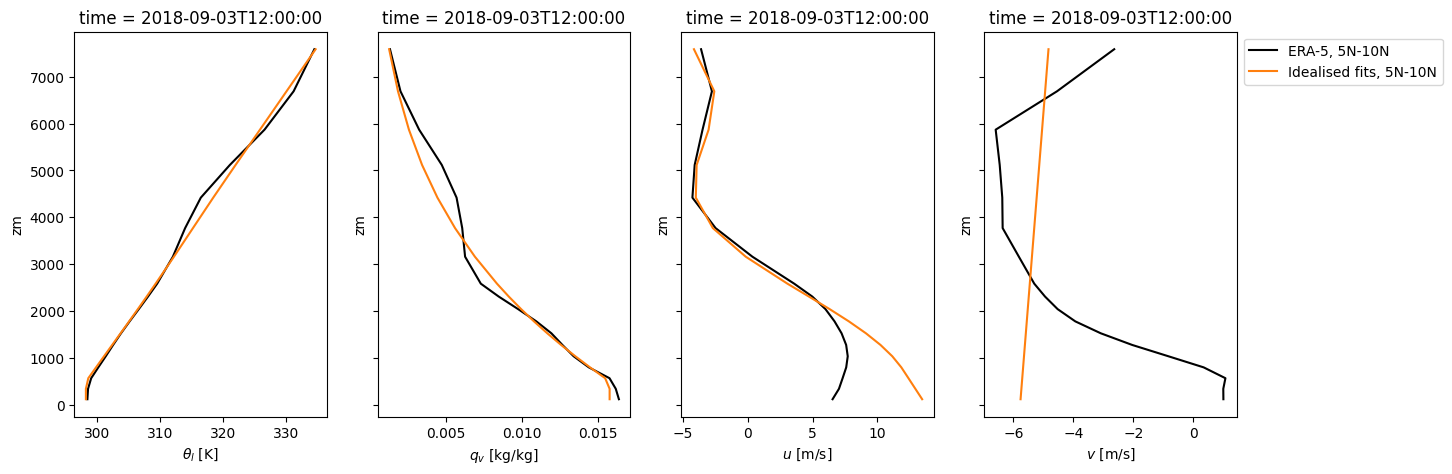

In [5]:
# Plot example
i = 0
j = 800

era5_env = xr.open_dataset(data_path+'/era5_env_'+doms[i]+'.nc')
zfit = era5_env['zm'].sel(zm=slice(zfitmax,zfitmin)).astype('float64')

# evaluate profiles on the era5 grid, over the fitting height
thl_fit = linml_sl(zfit, ds_fits.thls[i,j], ds_fits.dthllt[i,j])
qt_fit = exp(zfit, ds_fits.qt0[i,j], ds_fits.hqt[i,j])
u_fit = linv_aej(zfit, ds_fits.u0[i,j], ds_fits.dudz[i,j], ds_fits.ujet[i,j])
v_fit = linv(zfit, ds_fits.v0[i,j],ds_fits.dvdz[i,j])

era5_env_plt = era5_env.sel(zm=slice(zfitmax,zfitmin)).isel(time=j).mean('cell')

fig, axs = plt.subplots(ncols=4,figsize=(15,5),sharey=True)

era5_env_plt['theta_l'].plot(y='zm', ax=axs[0], color=cs[0], linestyle=lss[i])
axs[0].plot(thl_fit, zfit, color=cs[1], linestyle=lss[i])
axs[0].set_xlabel(r'$\theta_l$ [K]')

era5_env_plt['q'].plot(y='zm', ax=axs[1], color=cs[0], linestyle=lss[i])
axs[1].plot(qt_fit, zfit, color=cs[1], linestyle=lss[i])
axs[1].set_xlabel(r'$q_v$ [kg/kg]')

era5_env_plt['u'].plot(y='zm', ax=axs[2], color=cs[0], linestyle=lss[i])
axs[2].plot(u_fit, zfit, color=cs[1], linestyle=lss[i])
axs[2].set_xlabel(r'$u$ [m/s]')

era5_env_plt['v'].plot(y='zm', ax=axs[3], color=cs[0], linestyle=lss[i], label='ERA-5, '+lats[i])
axs[3].plot(v_fit, zfit, color=cs[1], linestyle=lss[i], label='Idealised fits, '+lats[i])
axs[3].set_xlabel(r'$v$ [m/s]')

axs[3].legend(bbox_to_anchor=(1,1), loc='best')

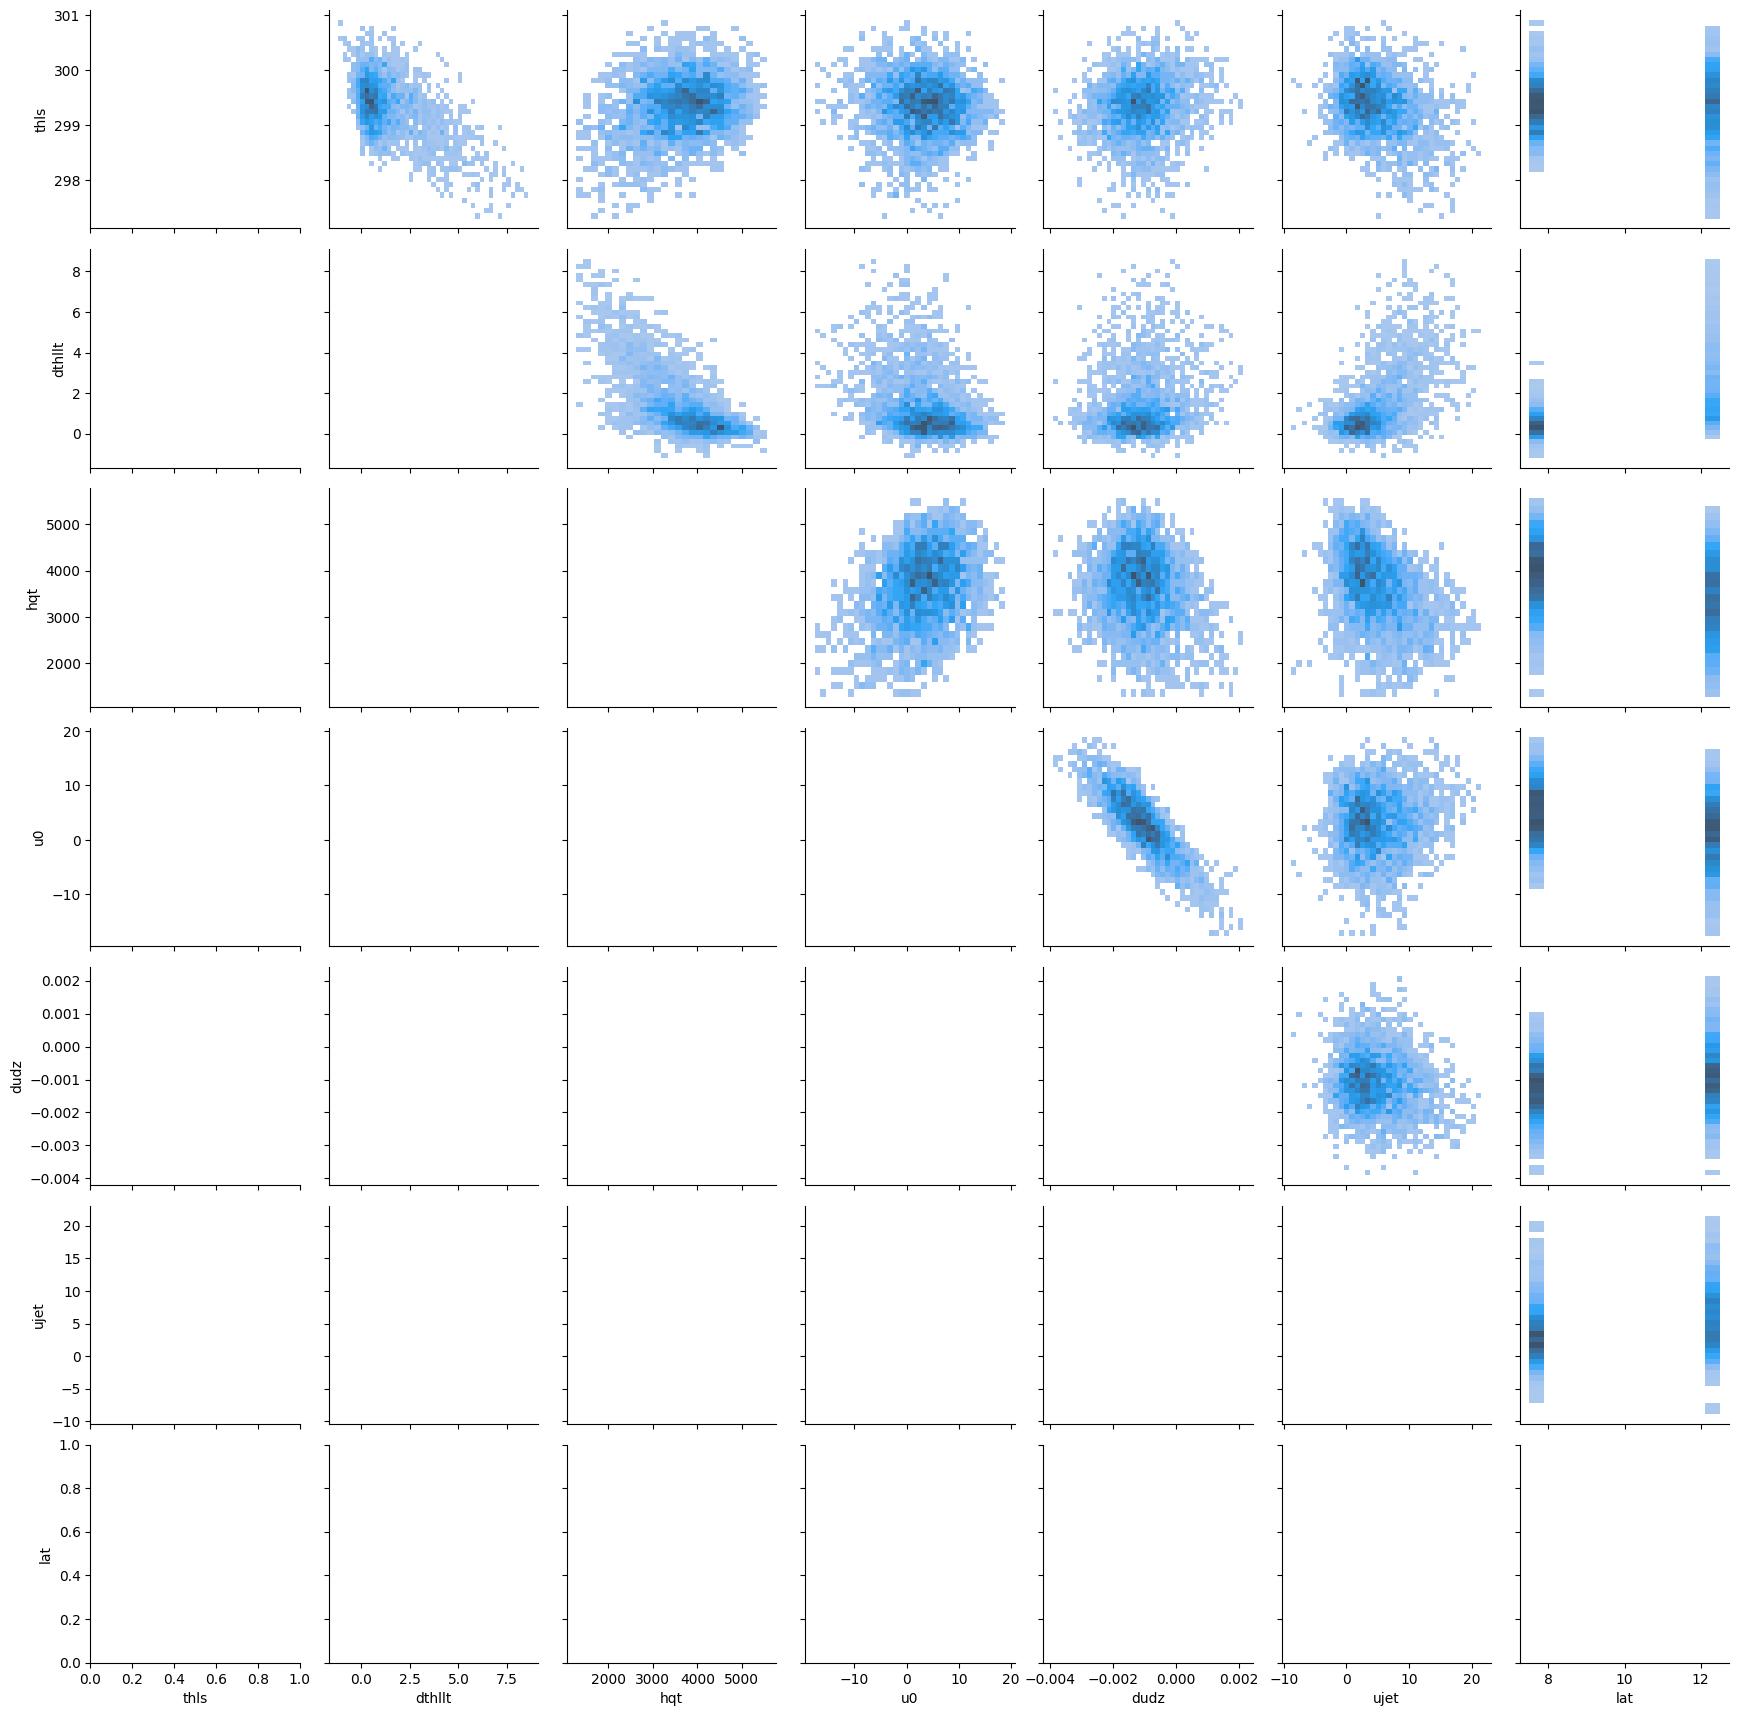

In [6]:
# Plot the distributions of these parameters
df_pars = ds_fits[['thls','dthllt','hqt','u0','dudz','ujet']].stack(z=('lat','time')).to_dataframe()
g = sns.PairGrid(df_pars)
g.map_upper(sns.histplot)

- Strong correlations between u0 and dudz => Should we vary these together? Does dudz matter compared to the shear induced by ujet?
  - u0 and ujet are not strongly correlated, so we could vary those independently
- Strong temperature inversions correlate to quick moisture dropoffs (as expected)
- But also to colder SSTs (as expected)

Free parameters are then:
- latitude (for diurnal cycle and Coriolis)
- SST
- Stability
- Moisture dropoff
- u0
- ujet (as a measure of dudz)
- nc

For the other cube, we also had wls, and we only swept in dudz and nc.

## Second iteration of fitting
Main goal is to reduce the free parameters, while capturing the varied range better:
- Zero meridional velocity
- Ignore vertical wind shear variation and only use ujet
- Use the actual `theta_ls` variability
- Use a fixed `qt0`, and add a lower tropospheric moisture deficit which scales with `hqt`, to avoid overly moist lower FTs or overly dry higher FTs

In [7]:
var_fits = ['thls_era',
            'dthllt',
            'hqt',
            'u0',
            'ujet',
           ]
compute_parameters = False
if compute_parameters:
    # Initialise dataset
    # Test open to read dimensions...
    era5_env = xr.open_dataset(data_path+'/era5_env_s.nc')
    
    ds_fits_c = xr.Dataset(coords={'lat':np.array([7.5, 12.5]),
                                 'time':era5_env.coords['time']})
    for i in range(len(var_fits)):
        ds_fits_c[var_fits[i]] = xr.DataArray(np.zeros((ds_fits.coords['lat'].size, ds_fits.coords['time'].size))*np.nan,
                                              coords={'lat':ds_fits.lat, 'time':ds_fits.time},
                                              dims=('lat','time'))
    # Dataset tracking vertically averaged errors in the fit profiles
    ds_err_c= xr.Dataset(coords={'lat':np.array([7.5, 12.5]),
                               'time':era5_env.coords['time']})    
    ds_err_c['theta_l'] = xr.DataArray(np.nan,coords={'lat':ds_err.lat,'time':ds_err.time}, dims=('lat','time'))
    ds_err_c['thls'] = xr.DataArray(np.nan,coords={'lat':ds_err.lat,'time':ds_err.time}, dims=('lat','time'))
    ds_err_c['qt'] = xr.DataArray(np.nan,coords={'lat':ds_err.lat,'time':ds_err.time}, dims=('lat','time'))
    ds_err_c['u'] = xr.DataArray(np.nan,coords={'lat':ds_err.lat,'time':ds_err.time}, dims=('lat','time'))
    ds_err_c['v'] = xr.DataArray(np.nan,coords={'lat':ds_err.lat,'time':ds_err.time}, dims=('lat','time'))
    
    for i in range(len(doms)):
    
        print('Domain:', doms[i])
    
        # ERA5 from DKRZ (Create-era5.ipynb)
        era5_env = xr.open_dataset(data_path+'/era5_env_'+doms[i]+'.nc')
    
        # Interpolate HERA5 to lat/lon    
        era5_env = utils.interpolate_to_latlon(era5_env)
    
        # Define fitting heights
        zfit = era5_env['zm'].sel(zm=slice(zfitmax,zfitmin)).astype('float64')
        zfit_u = era5_env['zm'].sel(zm=slice(zfitmax,zfitminu)).astype('float64')
    
        # Loop over time (daily aggregates)
        ind = 0
        for j in range(len(era5_env.time)):
    
            era5_envj = era5_env.isel(time=j).mean(['lat','lon'])
    
            # Use HERA5 (from DKRZ) for fits in lower troposphere
            era5_env_fit = era5_envj.sel(zm=slice(zfitmax,zfitmin)).astype('float64')
            
            # Use a different range for u, to avoid fitting near-surface mixing which we want to model
            era5_env_fit_u = era5_envj.sel(zm=slice(zfitmax,zfitminu)).astype('float64')
    
            # Actual surface pressure and surface theta_l from the data
            thls = era5_envj['sst']*(1e5/era5_envj['sp'].isel(zm=-1))**(2./7)

            # fit profiles
            # thl (including thls)
            [thlsf,dthllt], pcth = curve_fit(linml_sl,
                                            zfit, 
                                            era5_env_fit['theta_l'], 
                                            p0=[300,0.1])
            
            [hqt], pcqt = curve_fit(exp_h_lt,
                                  zfit,
                                  era5_env_fit['q'],
                                  p0=1500)
        
            [u0,ujet], pcu = curve_fit(linv_aej_fs,
                                       zfit_u,
                                       era5_env_fit_u['u'],
                                       p0=[-1,6])
                        
            # Write to ds (along with profile it produces)
            ds_fits_c['thls_era'][i,j] = thls
            ds_fits_c['dthllt'][i,j] = dthllt
            ds_fits_c['hqt'][i,j] = hqt
            ds_fits_c['u0'][i,j] = u0
            ds_fits_c['ujet'][i,j] = ujet

            # evaluate profiles on the era5 grid, over the fitting height
            thl_fit = linml_sl(zfit, ds_fits.thls[i,j], ds_fits.dthllt[i,j])
            qt_fit = exp_h(zfit, ds_fits.hqt[i,j])
            u_fit = linv_aej_fs(zfit, ds_fits.u0[i,j], ds_fits.ujet[i,j])
            v_fit = np.zeros(zfit.size)
    
            # evalute the rms
            ds_err_c['thls'][i,j] = np.sqrt(((thls - thls)**2).mean()) # Zero by def.
            ds_err_c['theta_l'][i,j] = utils.compute_rms(thl_fit, era5_env_fit, 'theta_l')
            ds_err_c['qt'][i,j] = utils.compute_rms(qt_fit, era5_env_fit, 'q')
            ds_err_c['u'][i,j] = utils.compute_rms(u_fit, era5_env_fit, 'u')
            ds_err_c['v'][i,j] = utils.compute_rms(v_fit, era5_env_fit, 'v')
            
            ind += 1
    
            if ind%100 == 0:
                print('Done', ind, ' / ', ds_fits.time.size)
            
    ds_fits_c.to_netcdf(data_path+'/fits-parameters-cube.nc',mode='w')
    ds_err_c.to_netcdf(data_path+'/fits-error-cube.nc',mode='w')
else:
    ds_fits_c = xr.open_dataset(data_path+'/fits-parameters-cube.nc')
    ds_err_c = xr.open_dataset(data_path+'/fits-error-cube.nc')


In [8]:
ds_err_c.mean()-ds_err.mean()
# Errors grow slightly in u and v => Acceptably

<xarray.Dataset> Size: 40B
Dimensions:  ()
Data variables:
    theta_l  float64 8B 0.0
    thls     float64 8B -0.5455
    qt       float64 8B 0.000186
    u        float64 8B 1.512
    v        float64 8B 0.9946

In [9]:
ds_err_c.mean()

<xarray.Dataset> Size: 40B
Dimensions:  ()
Data variables:
    theta_l  float64 8B 0.4957
    thls     float64 8B 0.0
    qt       float64 8B 0.000755
    u        float64 8B 3.279
    v        float64 8B 2.767

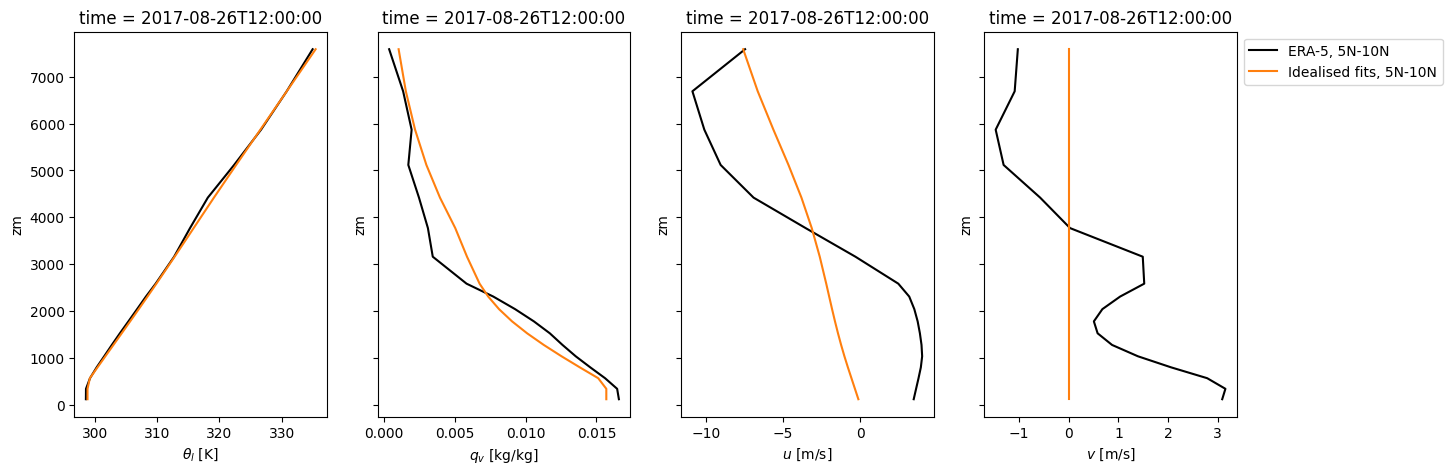

In [10]:
# Plot examples from the new cube
i = 0
j = 700

era5_env = xr.open_dataset(data_path+'/era5_env_'+doms[i]+'.nc')
zfit = era5_env['zm'].sel(zm=slice(zfitmax,zfitmin)).astype('float64')

# evaluate profiles on the era5 grid, over the fitting height
thl_fit = linml_sl(zfit, ds_fits_c.thls_era[i,j], ds_fits_c.dthllt[i,j])
qt_fit = exp_h_lt(zfit, ds_fits_c.hqt[i,j])
u_fit = linv_aej_fs(zfit, ds_fits_c.u0[i,j], ds_fits_c.ujet[i,j])
v_fit = np.zeros(zfit.size)

era5_env_plt = era5_env.sel(zm=slice(zfitmax,zfitmin)).isel(time=j).mean('cell')

fig, axs = plt.subplots(ncols=4,figsize=(15,5),sharey=True)

era5_env_plt['theta_l'].plot(y='zm', ax=axs[0], color=cs[0], linestyle=lss[i])
axs[0].plot(thl_fit, zfit, color=cs[1], linestyle=lss[i])
axs[0].set_xlabel(r'$\theta_l$ [K]')

era5_env_plt['q'].plot(y='zm', ax=axs[1], color=cs[0], linestyle=lss[i])
axs[1].plot(qt_fit, zfit, color=cs[1], linestyle=lss[i])
axs[1].set_xlabel(r'$q_v$ [kg/kg]')

era5_env_plt['u'].plot(y='zm', ax=axs[2], color=cs[0], linestyle=lss[i])
axs[2].plot(u_fit, zfit, color=cs[1], linestyle=lss[i])
axs[2].set_xlabel(r'$u$ [m/s]')

era5_env_plt['v'].plot(y='zm', ax=axs[3], color=cs[0], linestyle=lss[i], label='ERA-5, '+lats[i])
axs[3].plot(v_fit, zfit, color=cs[1], linestyle=lss[i], label='Idealised fits, '+lats[i])
axs[3].set_xlabel(r'$v$ [m/s]')

axs[3].legend(bbox_to_anchor=(1,1), loc='best')

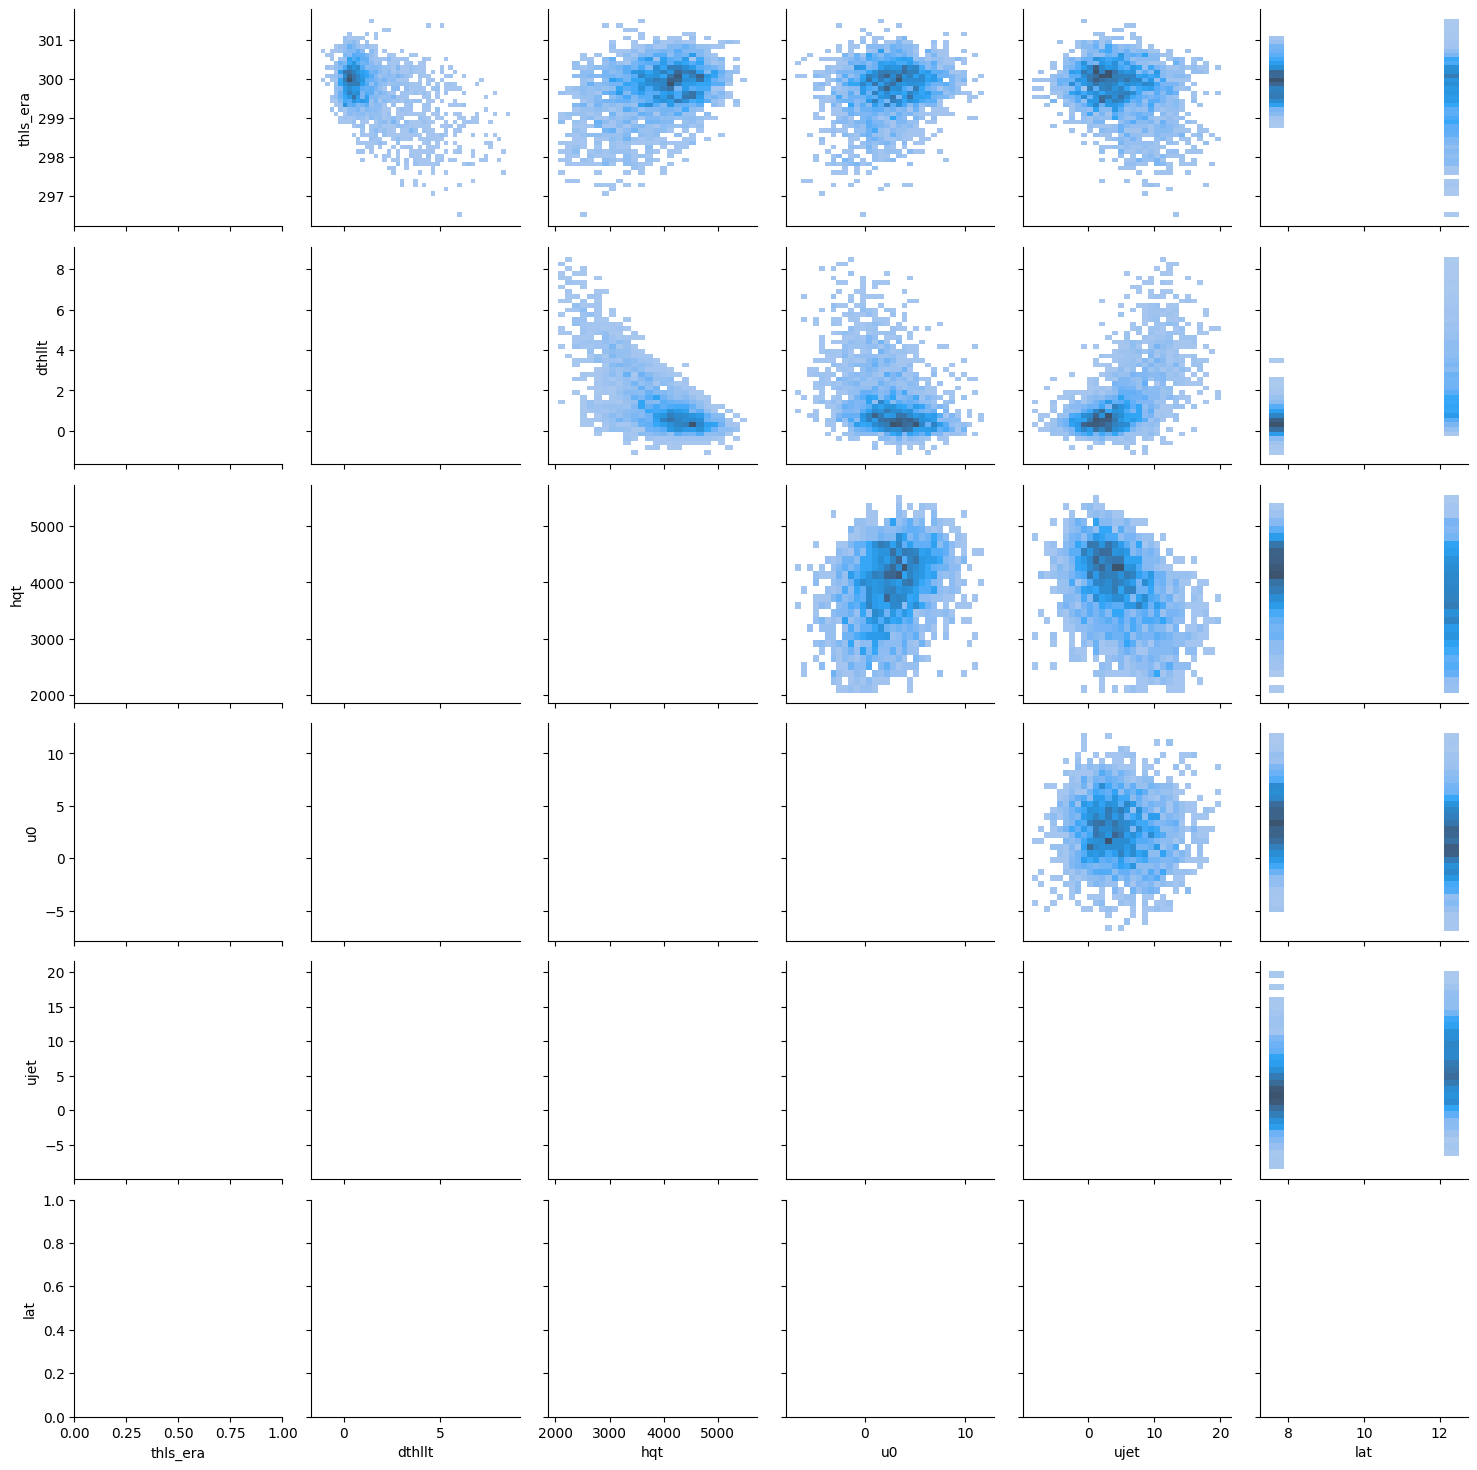

In [11]:
df_pars = ds_fits_c[['thls_era','dthllt','hqt','u0','ujet']].stack(z=('lat','time')).to_dataframe()
g = sns.PairGrid(df_pars)
g.map_upper(sns.histplot)

In [12]:
corr = df_pars.corr()
corr.style.background_gradient(cmap='coolwarm')

,thls_era,dthllt,hqt,u0,ujet,lat,time
thls_era,1.000000,-0.483871,0.332928,0.211466,-0.268447,-0.321511,0.083968
dthllt,-0.483871,1.000000,-0.699894,-0.358322,0.601179,0.603799,-0.026238
hqt,0.332928,-0.699894,1.000000,0.297104,-0.398736,-0.311460,0.044010
u0,0.211466,-0.358322,0.297104,1.000000,-0.074097,-0.266819,0.011050
ujet,-0.268447,0.601179,-0.398736,-0.074097,1.000000,0.401821,-0.018115
lat,-0.321511,0.603799,-0.311460,-0.266819,0.401821,1.000000,-0.000000
time,0.083968,-0.026238,0.044010,0.011050,-0.018115,-0.000000,1.000000


Correlations are pretty high between
- SST and stability, which makes sense if we are moving away from the ITCZ over colder waters with stronger inversions
- More stable lower FTs are usually also drier

We risk making corners based on independently varying parameters over ranges that depict climatological co-variance. You will never encounter the most stable and moistest FT combo in our hypercube. Need to think more about how to handle this. Should we make an actual cube in these parameters? Should the parameters just vary less? Should we instead sample from the high-density regions in parameter space?

## Pick parameter ranges
The table `ranges` defines the end points of variations in each parameter.

In [31]:
qu = 0.1 # Baseline values are 10-90 percentiles

# Baseline table (free parameters)
par = [ 'thls_era', 'dthllt', 'hqt', 'u0', 'ujet']

mi = ds_fits_c[par].quantile(qu)
ma = ds_fits_c[par].quantile(1-qu)
ranges = xr.concat([mi,ma],dim='minmax').to_pandas()

# Manual adjustments (rounding, sensible values...)
ranges.loc[0,'thls_era'] = 298.5 # Include slightly colder SSTs
ranges.loc[1,'thls_era'] = 301 # And slightly warmer SSTs
ranges.loc[0,'dthllt'] = 0.0 # Make the minimum value be a profile without any additional stability
ranges.loc[1,'dthllt'] = 4. # Increase max stability to a round number
ranges.loc[0,'hqt'] = 2700. # Include some drier lower FTs
ranges.loc[1,'hqt'] = 4750. # Include slightly moister FTs
ranges.loc[0,'u0'] = -5. # Some larger surface wind speeds to boost fluxes
ranges.loc[1,'u0'] = 10. # Some larger surface wind speeds to boost fluxes
ranges.loc[0,'ujet'] = 0.0 # Jet shouldn't be positive
ranges.loc[1,'ujet'] = 10.0 # Rounded up

## Second iteration of manual adjustments, after small cube attempt
ranges.loc[0,'thls_era'] = 299. # Warm the coldest point, which produces too much low-level cloud
ranges.loc[1,'thls_era'] = 301.5 # Upwards adjustment of the SST high point
ranges.loc[0,'dthllt'] = -0.5 # Slightly unstable, with a stable layer on top
ranges.loc[1,'dthllt'] = 2. # Max stability prevented cloudiness beyond trade inversion
ranges.loc[0,'hqt'] = 3000. # Less dry dry FTs
# ranges.loc[1,'hqt'] = 4500. # The moistest FTs were a bit too adventurous

ranges

,thls_era,dthllt,hqt,u0,ujet,quantile
minmax,,,,,,
0,299.0,-0.5,3000.0,-5.0,0.0,0.1
1,301.5,2.0,4750.0,10.0,10.0,0.9


## Creating profiles for paramter ranges
- First get the reference state to which we relax all profiles above the troposphere (same as in Profile-designer.ipynb for the cube centers)
- Get the range of variability of ERA5
- Import the cube centers
- Define the profiles
- Plot them

In [32]:
## Reference
grav = 9.81

# Surface pressure to use for all runs
ps_fixed = 101300. # Pa

# Manually retrieved ERA5 from Copernicus (used for higher levels, which do not exist in HERA5 from DKRZ)
era5_allplev = xr.open_dataset(data_path+'/era5_month_allplev_s.nc').sel(expver=1)
era5_allplev['zm'] = (era5_allplev['z']/grav).mean(['time','latitude','longitude'])
era5_allplev = era5_allplev.set_coords(['zm']).swap_dims({'level':'zm'})
era5_allplev['pres'] = era5_allplev['level'] * 100
era5_allplev['theta_l']  = (1e5/era5_allplev['pres'])**(2/7)*(era5_allplev['t'])
era5_allplev_mn = era5_allplev.mean(['time','latitude','longitude'])
era5_ref = era5_allplev_mn.copy(deep=True)

# Interpolate pressure to model grid for RH calculations
pres = (era5_allplev_mn['level']*100)
pres_np = np.flip(np.append(pres.to_numpy(),ps_fixed))
zm_np = np.flip(np.append(pres['zm'].to_numpy(), 0.))
pres = xr.DataArray(data=pres_np, coords={'zm':zm_np})
pres_zf = pres.interp(zm=zf,kwargs={"fill_value": "extrapolate"})

Actual thls - thl[0]: 1.25
Max RH: 95.49796778625895
Actual thls - thl[0]: 1.25
Max RH: 95.49796778625895
Actual thls - thl[0]: 1.25
Max RH: 95.49796778625895
Actual thls - thl[0]: 1.25
Max RH: 95.49796778625895
Actual thls - thl[0]: 1.25
Max RH: 97.16480381107812
Actual thls - thl[0]: 1.25
Max RH: 97.16480381107812
Actual thls - thl[0]: 1.25
Max RH: 97.16480381107812
Actual thls - thl[0]: 1.25
Max RH: 97.16480381107812
Actual thls - thl[0]: 1.25
Max RH: 94.86784481253048
Actual thls - thl[0]: 1.25
Max RH: 94.86784481253048
Actual thls - thl[0]: 1.25
Max RH: 94.86784481253048
Actual thls - thl[0]: 1.25
Max RH: 94.86784481253048
Actual thls - thl[0]: 1.25
Max RH: 95.75291327744448
Actual thls - thl[0]: 1.25
Max RH: 95.75291327744448
Actual thls - thl[0]: 1.25
Max RH: 95.75291327744448
Actual thls - thl[0]: 1.25
Max RH: 95.75291327744448
Actual thls - thl[0]: 1.25
Max RH: 82.02480952225001
Actual thls - thl[0]: 1.25
Max RH: 82.02480952225001
Actual thls - thl[0]: 1.25
Max RH: 82.02480952

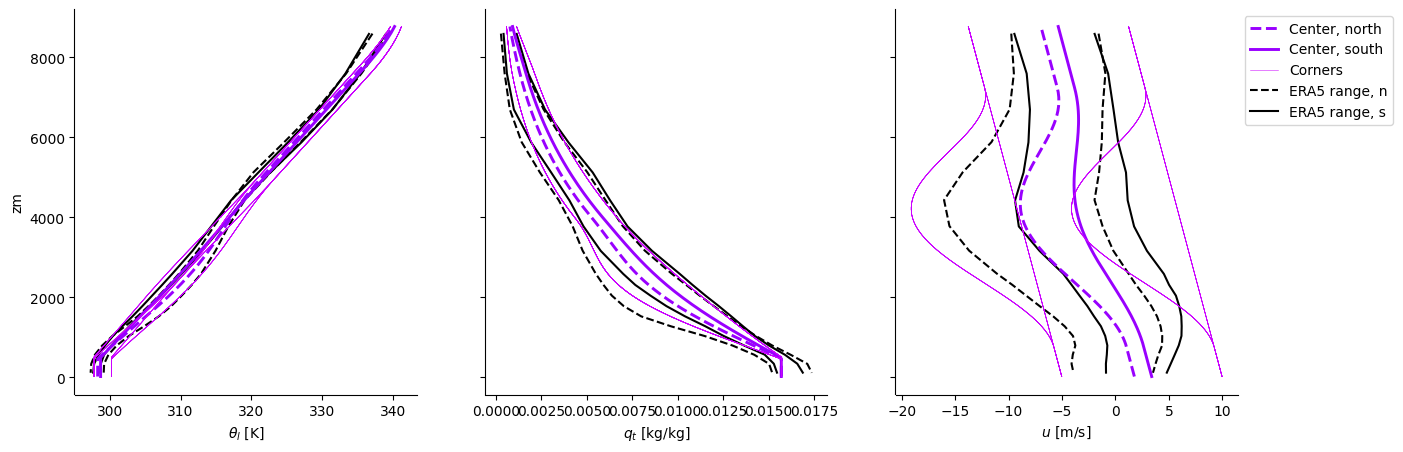

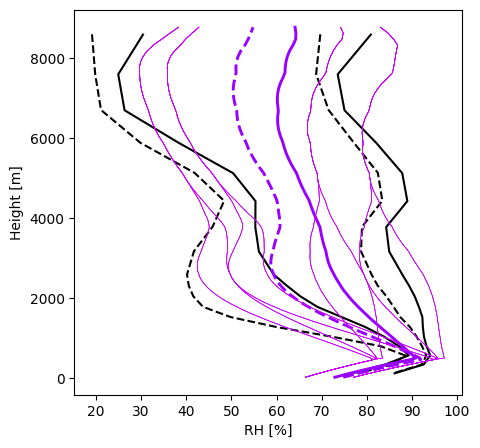

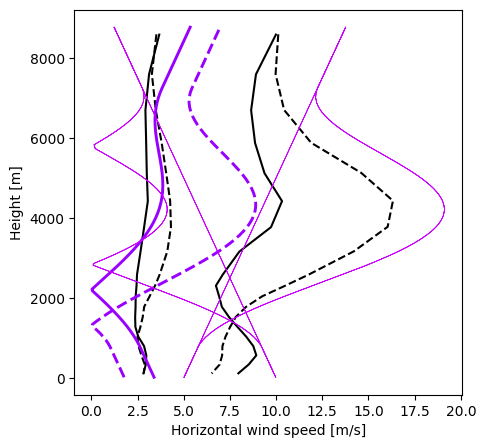

In [33]:
# Create profiles for parameter ranges

# relax profiles back to the reference state using ERA5, which is
# - the southern domain mean upper troposphere for q/theta_l
# - zero for u and v
href_relax=9e3 # Relax to same profile in the upper troposphere, which we do not control
hsca_relax=3e3
href_relax_u=19e3 # Above the tropopause, relax to zero
hsca_relax_u=7e3

# plotting range
zpltmax = 9e3
izmax = np.where(zf<zpltmax)[0][-1]

# Plot settings
cs = ['black',(0.6,0,1),(0.8,0,1,.9),'limegreen']
lss = ['-','--']
lws = [2.1, 0.4]

# Where to store output files
figs_dir = './data/figures'
out_dir = './runs'

# Quantile to plot
qu = 0.1

# Figures
fig, axs = plt.subplots(ncols=3,figsize=(15,5),sharey=True)
fig_rh, ax_rh = plt.subplots(ncols=1,figsize=(5,5))
fig_u, ax_u = plt.subplots(ncols=1,figsize=(5,5))

# ERA5 - extract limits of 10-90% from both south and north, and plot as lines
for i in range(len(doms)):
    
    era5_env = xr.open_dataset(data_path+'/era5_env_'+doms[i]+'.nc').sel(zm=slice(zpltmax,0)).mean('cell')

    era5_env_mi = era5_env.quantile(qu, dim='time')
    era5_env_ma = era5_env.quantile(1-qu, dim='time')
    
    # Add to plots
    era5_env_mi['theta_l'].plot(y='zm', ax=axs[0], color=cs[0], linestyle=lss[i])
    era5_env_ma['theta_l'].plot(y='zm', ax=axs[0], color=cs[0], linestyle=lss[i])

    era5_env_mi['q'].plot(y='zm', ax=axs[1], color=cs[0], linestyle=lss[i])
    era5_env_ma['q'].plot(y='zm', ax=axs[1], color=cs[0], linestyle=lss[i])

    era5_env_mi['u'].plot(y='zm', ax=axs[2], color=cs[0], linestyle=lss[i], label='ERA5 range, '+doms[i])
    era5_env_ma['u'].plot(y='zm', ax=axs[2], color=cs[0], linestyle=lss[i])

    era5_env_mi['r'].plot(y='zm', ax=ax_rh, color=cs[0], linestyle=lss[i])
    era5_env_ma['r'].plot(y='zm', ax=ax_rh, color=cs[0], linestyle=lss[i])

    era5_env_mi['U'].plot(y='zm', ax=ax_u, color=cs[0], linestyle=lss[i])
    era5_env_ma['U'].plot(y='zm', ax=ax_u, color=cs[0], linestyle=lss[i])

# Cube centre (from Profile-designer.ipynb)

# s
pars_s = pd.read_csv(out_dir+'/run_1/parameters.csv').to_dict('records')[0]
thl_s = linml_sl(zf, pars_s['thls'], pars_s['dthllt'])
qt_s = exp_h_lt(zf, pars_s['hqt'])
u_s = linv_aej_fs(zf, pars_s['u0'], pars_s['ujet'])
thl_s, qt_s, u_s = relax_all(zf, thl_s, qt_s, u_s, era5_ref, href_relax, hsca_relax, href_relax_u, hsca_relax_u)

rh_s = rhProf(thl_s.to_numpy(), qt_s.to_numpy(), pres_zf.to_numpy())
U_s = np.sqrt(u_s**2)

axs[0].plot(thl_s[:izmax], zf[:izmax], color=cs[1], linestyle=lss[0], lw=lws[0])
axs[1].plot(qt_s[:izmax], zf[:izmax], color=cs[1], linestyle=lss[0], lw=lws[0])
axs[2].plot(u_s[:izmax], zf[:izmax], color=cs[1], linestyle=lss[0], lw=lws[0], label='Center, south')
ax_rh.plot(rh_s[:izmax], zf[:izmax], color=cs[1], linestyle=lss[0], lw=lws[0])
ax_u.plot(U_s[:izmax], zf[:izmax], color=cs[1], linestyle=lss[0], lw=lws[0])

# n
pars_n = pd.read_csv(out_dir+'/run_2/parameters.csv').to_dict('records')[0]
thl_n = linml_sl(zf, pars_n['thls'], pars_n['dthllt'])
qt_n = exp_h_lt(zf, pars_n['hqt'])
u_n = linv_aej_fs(zf, pars_n['u0'], pars_n['ujet'])
thl_n, qt_n, u_n = relax_all(zf, thl_n, qt_n, u_n, era5_ref, href_relax, hsca_relax, href_relax_u, hsca_relax_u)

rh_n = rhProf(thl_n.to_numpy(), qt_n.to_numpy(), pres_zf.to_numpy())
U_n = np.sqrt(u_n**2)

axs[0].plot(thl_n[:izmax], zf[:izmax], color=cs[1], linestyle=lss[1], lw=lws[0])
axs[1].plot(qt_n[:izmax], zf[:izmax], color=cs[1], linestyle=lss[1], lw=lws[0])
axs[2].plot(u_n[:izmax], zf[:izmax], color=cs[1], linestyle=lss[1], lw=lws[0], label='Center, north')
ax_rh.plot(rh_n[:izmax], zf[:izmax], color=cs[1], linestyle=lss[1], lw=lws[0])
ax_u.plot(U_n[:izmax], zf[:izmax], color=cs[1], linestyle=lss[1], lw=lws[0])

## Cube corners
# Could probably do this in a nice way, but can't find it quickly so bodging...
for i in range(2):
    thlsi = ranges['thls_era'].iloc[i]
    for j in range(2):
        dthlltj = ranges['dthllt'].iloc[j]
        for k in range(2):
            hqtk = ranges['hqt'].iloc[k]
            for l in range(2):
                u0l = ranges['u0'].iloc[l]
                for m in range(2):
                    ujetm = ranges['ujet'].iloc[m]

                    ## Make profile
                    thl = linml_sl(zf, thlsi, dthlltj)
                    qt = exp_h_lt(zf, hqtk)
                    u = linv_aej_fs(zf, u0l, ujetm)
                    thl, qt, u = relax_all(zf, thl, qt, u, era5_ref, href_relax, hsca_relax, href_relax_u, hsca_relax_u)

                    ## Checks
                    # check that thls>thl[0]
                    dthls0 = thlsi-thl[0]
                    print('Actual thls - thl[0]:', dthls0.values)
                    
                    # Check RH
                    rh = rhProf(thl.to_numpy(), qt.to_numpy(), pres_zf.to_numpy())
                    print('Max RH:', np.max(rh))
                
                    # Check momentum
                    # mean-flow total momentum (not equal mean of total momentum)
                    U = np.sqrt(u**2)

                    # Plot
                    axs[0].plot(thl[:izmax], zf[:izmax], color=cs[2], lw=lws[1])
                    axs[1].plot(qt[:izmax], zf[:izmax], color=cs[2], lw=lws[1])
                    axs[2].plot(u[:izmax], zf[:izmax], color=cs[2], lw=lws[1], label='Corners')
                    
                    # Plot RH
                    ax_rh.plot(rh[:izmax], zf[:izmax], color=cs[2], lw=lws[1])

                    # Plot U
                    ax_u.plot(U[:izmax], zf[:izmax], color=cs[2], lw=lws[1])

# Plot makeup
axs[0].set_xlabel(r'$\theta_l$ [K]')
axs[1].set_xlabel(r'$q_t$ [kg/kg]')
axs[1].set_ylabel(r'')
axs[2].set_xlabel(r'$u$ [m/s]')
axs[2].set_ylabel(r'')
for i in range(3):
    axs[i].set_title(r'')
sns.despine(fig, offset=0.5)

handles, labels = axs[2].get_legend_handles_labels()
labels, ids = np.unique(labels, return_index=True)
handles = [handles[i] for i in ids]
axs[2].legend(handles, labels, bbox_to_anchor=(1,1), loc='best')

fig.savefig(figs_dir+'/prof-test.pdf',bbox_inches='tight')

ax_rh.set_xlabel('RH [%]')
ax_rh.set_ylabel('Height [m]')
ax_rh.set_title('')
fig_rh.savefig(figs_dir+'/prof-rh.pdf',bbox_inches='tight')

ax_u.set_xlabel('Horizontal wind speed [m/s]')
ax_u.set_ylabel('Height [m]')
ax_u.set_title('')
fig_u.savefig(figs_dir+'/prof-U.pdf',bbox_inches='tight')

Open questions cube design:
- How do we treat horizontal advection? Do we ignore it and run all cases with nudging?
- Do we add a WTG moisture import term?
- Must we update RRTMGP with ice fix before running cubes?
- Should we really vary `hqt` independently, if most of its variance is explained by `dthllt`?